In [51]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, matthews_corrcoef
import time
import pickle
import os
import random

# Configuración para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuración para visualizaciones
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Cargar datos procesados
print("Cargando datos procesados...")

try:
    # Cargar datos de entrenamiento y prueba
    X_train = np.load('X_train_reducido.npy')
    X_test = np.load('X_test_reducido.npy')
    y_train = np.load('y_train_simple_reducido.npy')
    y_test = np.load('y_test_simple_reducido.npy')
    
    print(f"X_train: {X_train.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Cargar codificador de etiquetas
    with open('label_encoder_simple_reducido.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    print(f"Número de clases únicas: {len(label_encoder.classes_)}")
    
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    import traceback
    traceback.print_exc()

Cargando datos procesados...
X_train: (11499, 15209)
X_test: (2875, 15209)
y_train: (11499,)
y_test: (2875,)
Número de clases únicas: 178


In [13]:
# Función para evaluar el modelo en ambos conjuntos (entrenamiento y prueba)
def evaluar_modelo(modelo, X_train, y_train, X_test, y_test, nombre_modelo=""):
    """
    Evalúa el modelo en conjuntos de entrenamiento y prueba, y muestra métricas comparativas.
    """
    # Evaluar en conjunto de entrenamiento
    y_pred_train = modelo.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    recall_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    
    # Evaluar en conjunto de prueba
    y_pred_test = modelo.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Calcular diferencias (para detectar sobreajuste)
    diff_accuracy = accuracy_train - accuracy_test
    diff_f1 = f1_train - f1_test
    
    print(f"\n===== EVALUACIÓN DEL MODELO: {nombre_modelo} =====")
    print("\nMétricas en conjunto de ENTRENAMIENTO:")
    print(f"  Accuracy:  {accuracy_train:.4f}")
    print(f"  Precision: {precision_train:.4f}")
    print(f"  Recall:    {recall_train:.4f}")
    print(f"  F1-Score:  {f1_train:.4f}")
    
    print("\nMétricas en conjunto de PRUEBA:")
    print(f"  Accuracy:  {accuracy_test:.4f}")
    print(f"  Precision: {precision_test:.4f}")
    print(f"  Recall:    {recall_test:.4f}")
    print(f"  F1-Score:  {f1_test:.4f}")
    
    print("\nDiferencia entre entrenamiento y prueba:")
    print(f"  Accuracy:  {diff_accuracy:.4f} ({diff_accuracy/accuracy_train*100:.1f}%)")
    print(f"  F1-Score:  {diff_f1:.4f} ({diff_f1/f1_train*100:.1f}%)")
    
    # Visualizar comparación
    plt.figure(figsize=(10, 6))
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    valores_train = [accuracy_train, precision_train, recall_train, f1_train]
    valores_test = [accuracy_test, precision_test, recall_test, f1_test]
    
    x = np.arange(len(metricas))
    width = 0.35
    
    plt.bar(x - width/2, valores_train, width, label='Entrenamiento', color='#3498db')
    plt.bar(x + width/2, valores_test, width, label='Prueba', color='#e74c3c')
    
    plt.xlabel('Métrica')
    plt.ylabel('Valor')
    plt.title(f'Comparación de métricas: {nombre_modelo}')
    plt.xticks(x, metricas)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Añadir valores sobre las barras
    for i, v in enumerate(valores_train):
        plt.text(i - width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    for i, v in enumerate(valores_test):
        plt.text(i + width/2, v + 0.02, f'{v:.3f}', ha='center')
    
    plt.tight_layout()
    plt.savefig(f'comparacion_{nombre_modelo.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    
    return {
        'train': {
            'accuracy': accuracy_train,
            'precision': precision_train,
            'recall': recall_train,
            'f1': f1_train
        },
        'test': {
            'accuracy': accuracy_test,
            'precision': precision_test,
            'recall': recall_test,
            'f1': f1_test
        },
        'diff': {
            'accuracy': diff_accuracy,
            'accuracy_pct': diff_accuracy/accuracy_train*100,
            'f1': diff_f1,
            'f1_pct': diff_f1/f1_train*100
        }
    }

Entrenando modelo base para referencia...
Tiempo de entrenamiento: 342.61 segundos

===== EVALUACIÓN DEL MODELO: Modelo Base =====

Métricas en conjunto de ENTRENAMIENTO:
  Accuracy:  0.9989
  Precision: 0.9989
  Recall:    0.9989
  F1-Score:  0.9989

Métricas en conjunto de PRUEBA:
  Accuracy:  0.7969
  Precision: 0.7886
  Recall:    0.7969
  F1-Score:  0.7858

Diferencia entre entrenamiento y prueba:
  Accuracy:  0.2020 (20.2%)
  F1-Score:  0.2131 (21.3%)


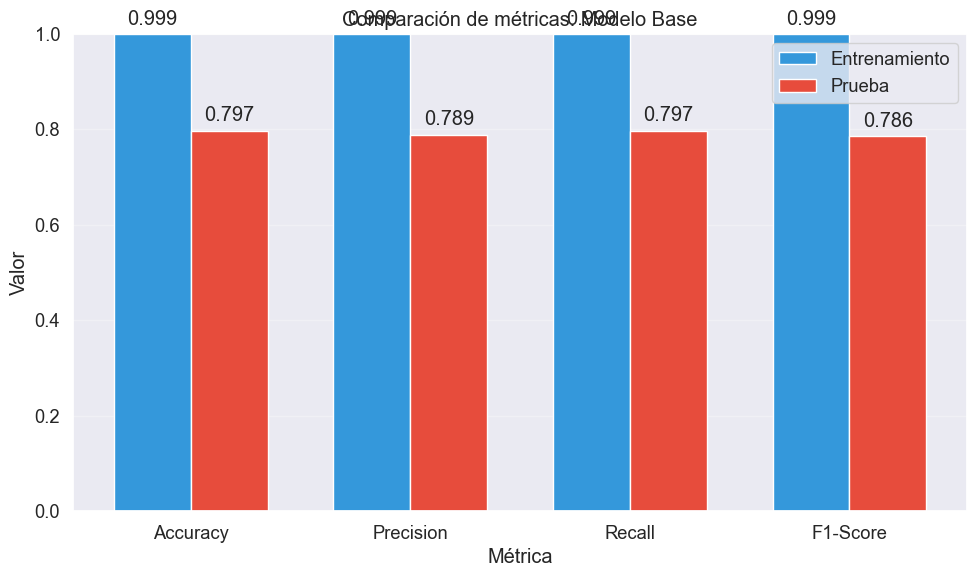

Matthews Correlation Coefficient (MCC): 0.7916
Modelo base guardado como 'modelo_base.pkl'


In [14]:
# Entrenar modelo base para tener una referencia
print("Entrenando modelo base para referencia...")

# Crear y entrenar el modelo base
nn_base = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=200,
    random_state=RANDOM_SEED
)

start_time = time.time()
nn_base.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

# Evaluar modelo base
metricas_base = evaluar_modelo(
    nn_base, X_train, y_train, 
    X_test, y_test, 
    "Modelo Base"
)

# Calcular MCC para el modelo base
y_pred_test_base = nn_base.predict(X_test)
mcc_base = matthews_corrcoef(y_test, y_pred_test_base)
print(f"Matthews Correlation Coefficient (MCC): {mcc_base:.4f}")

# Guardar modelo base
with open('modelo_base.pkl', 'wb') as f:
    pickle.dump({
        'modelo': nn_base,
        'metricas': metricas_base,
        'mcc': mcc_base,
        'tiempo_entrenamiento': training_time
    }, f)

print("Modelo base guardado como 'modelo_base.pkl'")


===== EXPERIMENTACIÓN CON DIFERENTES ARQUITECTURAS =====

Probando arquitectura: Una capa oculta (32 neuronas)
  TRAIN - Accuracy: 0.9765, F1-Score: 0.9764, MCC: 0.9759
  TEST  - Accuracy: 0.8129, F1-Score: 0.8004, MCC: 0.8081
  Tiempo: 189.69 segundos
  Iteraciones: 44
  Convergió: Sí
  Diferencia Train-Test - Accuracy: 0.1637, F1-Score: 0.1760
  ⚠️ Posible sobreajuste detectado

Probando arquitectura: Una capa oculta (64 neuronas)
  TRAIN - Accuracy: 0.9824, F1-Score: 0.9824, MCC: 0.9820
  TEST  - Accuracy: 0.8282, F1-Score: 0.8179, MCC: 0.8237
  Tiempo: 324.99 segundos
  Iteraciones: 48
  Convergió: Sí
  Diferencia Train-Test - Accuracy: 0.1543, F1-Score: 0.1644
  ⚠️ Posible sobreajuste detectado

Probando arquitectura: Una capa oculta (128 neuronas)
  TRAIN - Accuracy: 0.9832, F1-Score: 0.9831, MCC: 0.9828
  TEST  - Accuracy: 0.8268, F1-Score: 0.8179, MCC: 0.8224
  Tiempo: 438.97 segundos
  Iteraciones: 36
  Convergió: Sí
  Diferencia Train-Test - Accuracy: 0.1564, F1-Score: 0.165

<Figure size 1600x1000 with 0 Axes>

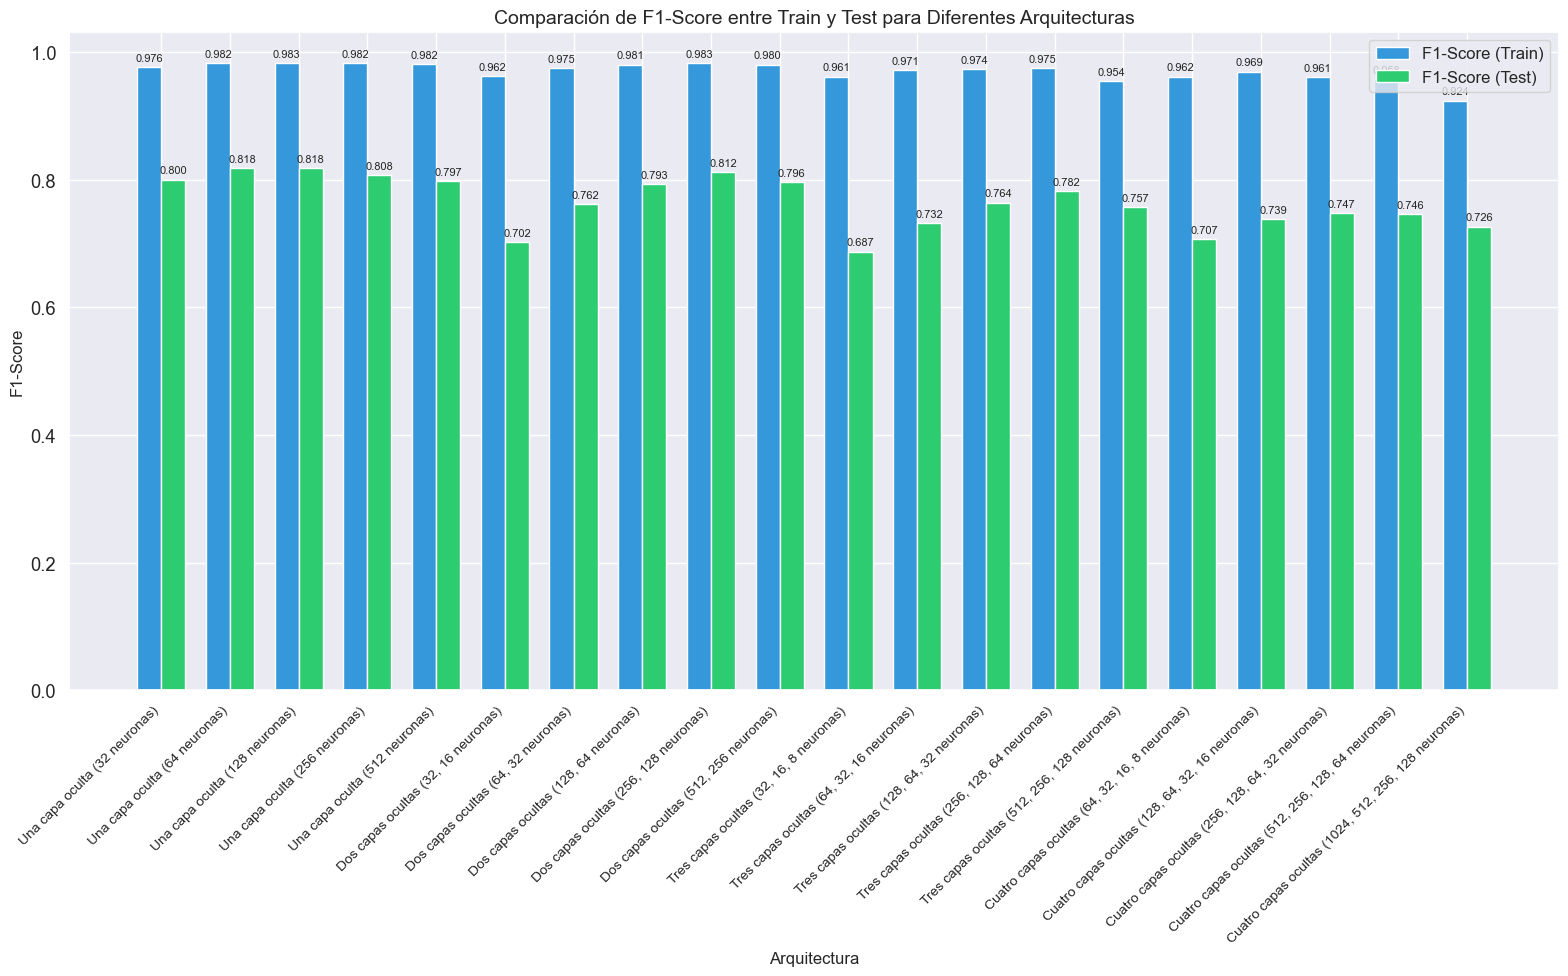

<Figure size 1400x800 with 0 Axes>

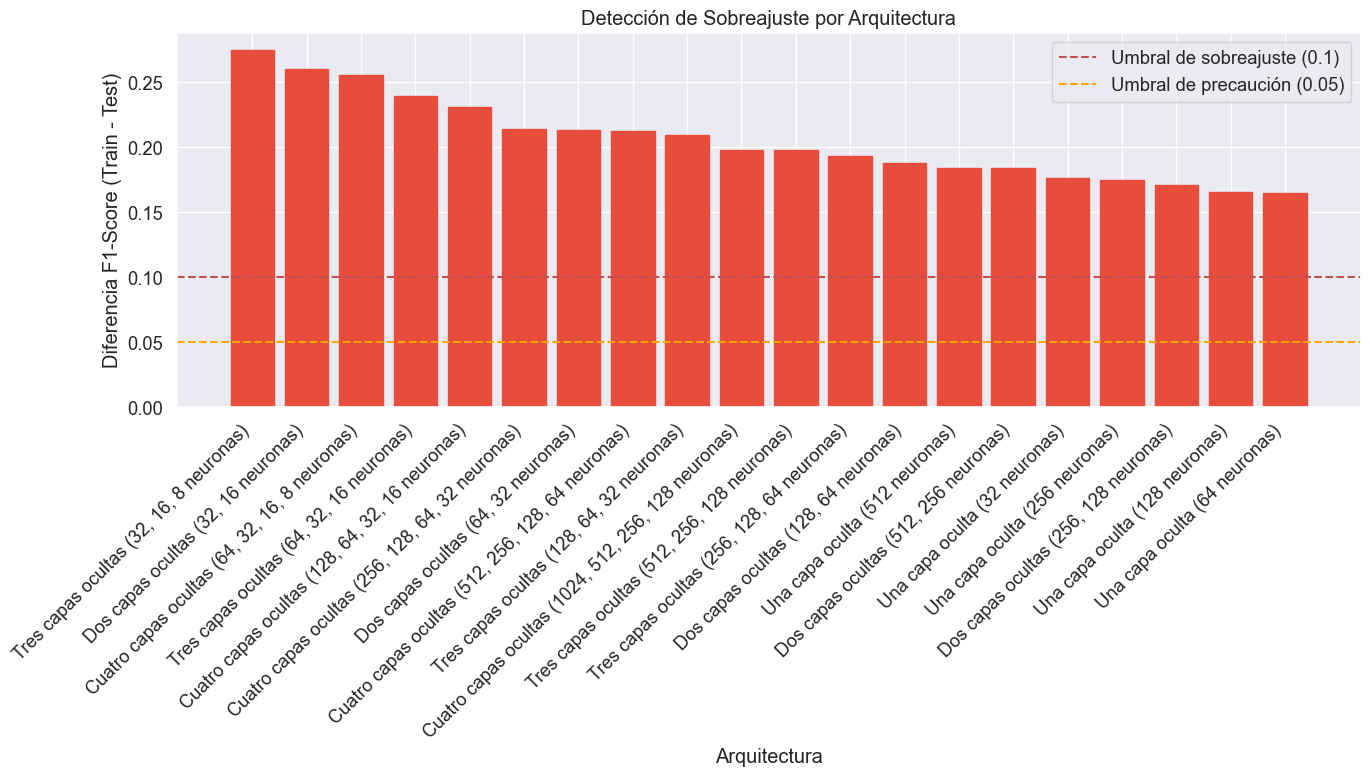

In [16]:
# Experimentación con diferentes arquitecturas
def experimentar_arquitecturas():
    print("\n===== EXPERIMENTACIÓN CON DIFERENTES ARQUITECTURAS =====")
    
    # Definir diferentes arquitecturas para probar
    arquitecturas = [
        ((32,),),
        ((64,),),
        ((128,),),
        ((256,),),
        ((512,),),
        ((32, 16),),
        ((64, 32),),
        ((128, 64),),
        ((256, 128),),
        ((512, 256),),
        ((32, 16, 8),),
        ((64, 32, 16),),
        ((128, 64, 32),),
        ((256, 128, 64),),
        ((512, 256, 128),),
        ((64, 32, 16, 8),),
        ((128, 64, 32, 16),),
        ((256, 128, 64, 32),),
        ((512, 256, 128, 64),),
        ((1024, 512, 256, 128),)
    ]
    
    # Parámetros base
    params_base = {
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0005,
        'batch_size': 64,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.002,
        'max_iter': 200,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'random_state': RANDOM_SEED
    }
    
    # Resultados
    resultados = []
    
    # Probar cada arquitectura
    for arquitectura, nombre in arquitecturas:
        print(f"\nProbando arquitectura: {nombre}")
        
        # Actualizar parámetros con la arquitectura actual
        params = params_base.copy()
        params['hidden_layer_sizes'] = arquitectura
        
        # Crear y entrenar modelo
        modelo = MLPClassifier(**params)
        
        start_time = time.time()
        modelo.fit(X_train_reducido_scaled, y_train_simple)
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de entrenamiento
        y_pred_train = modelo.predict(X_train_reducido_scaled)
        accuracy_train = accuracy_score(y_train_simple, y_pred_train)
        f1_train = f1_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
        mcc_train = matthews_corrcoef(y_train_simple, y_pred_train)
        
        # Evaluar en conjunto de prueba
        y_pred_test = modelo.predict(X_test_reducido_scaled)
        accuracy_test = accuracy_score(y_test_simple, y_pred_test)
        f1_test = f1_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
        mcc_test = matthews_corrcoef(y_test_simple, y_pred_test)
        
        # Guardar resultados
        resultados.append({
            'Arquitectura': nombre,
            'Accuracy_Train': accuracy_train,
            'F1-Score_Train': f1_train,
            'MCC_Train': mcc_train,
            'Accuracy_Test': accuracy_test,
            'F1-Score_Test': f1_test,
            'MCC_Test': mcc_test,
            'Tiempo (s)': training_time,
            'Num_Iteraciones': modelo.n_iter_,
            'Convergencia': modelo.n_iter_ < params['max_iter']
        })
        
        print(f"  TRAIN - Accuracy: {accuracy_train:.4f}, F1-Score: {f1_train:.4f}, MCC: {mcc_train:.4f}")
        print(f"  TEST  - Accuracy: {accuracy_test:.4f}, F1-Score: {f1_test:.4f}, MCC: {mcc_test:.4f}")
        print(f"  Tiempo: {training_time:.2f} segundos")
        print(f"  Iteraciones: {modelo.n_iter_}")
        print(f"  Convergió: {'Sí' if modelo.n_iter_ < params['max_iter'] else 'No'}")
        
        # Calcular diferencia entre train y test (para detectar sobreajuste)
        diff_accuracy = accuracy_train - accuracy_test
        diff_f1 = f1_train - f1_test
        print(f"  Diferencia Train-Test - Accuracy: {diff_accuracy:.4f}, F1-Score: {diff_f1:.4f}")
        if diff_accuracy > 0.1 or diff_f1 > 0.1:
            print("Posible sobreajuste detectado")
    
    # Crear DataFrame con resultados
    resultados_df = pd.DataFrame(resultados)
    print("\nResumen de resultados:")
    print(resultados_df)
    
    # Ordenar por F1-Score de test
    resultados_df_sorted = resultados_df.sort_values('F1-Score_Test', ascending=False).reset_index(drop=True)
    print("\nMejores arquitecturas por F1-Score en TEST:")
    print(resultados_df_sorted.head(5))
    
    # Visualizar resultados
    plt.figure(figsize=(16, 10))
    
    # Preparar datos para visualización
    arquitecturas = resultados_df['Arquitectura']
    f1_train = resultados_df['F1-Score_Train']
    f1_test = resultados_df['F1-Score_Test']
    
    # Crear gráfico de barras agrupadas
    x = np.arange(len(arquitecturas))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(16, 10))
    rects1 = ax.bar(x - width/2, f1_train, width, label='F1-Score (Train)', color='#3498db')
    rects2 = ax.bar(x + width/2, f1_test, width, label='F1-Score (Test)', color='#2ecc71')
    
    # Añadir etiquetas y leyenda
    ax.set_xlabel('Arquitectura', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title('Comparación de F1-Score entre Train y Test para Diferentes Arquitecturas', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(arquitecturas, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=12)
    
    # Añadir valores sobre las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig('comparacion_arquitecturas_train_test.png', dpi=300)
    plt.show()
    
    # Visualizar diferencia entre train y test
    plt.figure(figsize=(14, 8))
    
    # Calcular diferencia
    diff_f1 = resultados_df['F1-Score_Train'] - resultados_df['F1-Score_Test']
    
    # Ordenar arquitecturas por diferencia (mayor diferencia = más sobreajuste)
    idx_sorted = np.argsort(diff_f1)[::-1]
    arquitecturas_sorted = [arquitecturas.iloc[i] for i in idx_sorted]
    diff_f1_sorted = [diff_f1.iloc[i] for i in idx_sorted]
    
    # Crear gráfico de barras
    plt.figure(figsize=(14, 8))
    bars = plt.bar(range(len(arquitecturas_sorted)), diff_f1_sorted, color='#e74c3c')
    
    # Colorear barras según nivel de sobreajuste
    for i, bar in enumerate(bars):
        if diff_f1_sorted[i] > 0.1:
            bar.set_color('#e74c3c')  # Rojo para alto sobreajuste
        elif diff_f1_sorted[i] > 0.05:
            bar.set_color('#f39c12')  # Naranja para medio sobreajuste
        else:
            bar.set_color('#2ecc71')  # Verde para bajo sobreajuste
    
    plt.axhline(y=0.1, color='r', linestyle='--', label='Umbral de sobreajuste (0.1)')
    plt.axhline(y=0.05, color='orange', linestyle='--', label='Umbral de precaución (0.05)')
    
    plt.xlabel('Arquitectura')
    plt.ylabel('Diferencia F1-Score (Train - Test)')
    plt.title('Detección de Sobreajuste por Arquitectura')
    plt.xticks(range(len(arquitecturas_sorted)), arquitecturas_sorted, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sobreajuste_arquitecturas.png', dpi=300)
    plt.show()
    
    return resultados_df

# Ejecutar experimentación con diferentes arquitecturas
resultados_arquitecturas = experimentar_arquitecturas()

In [23]:
def experimentar_arquitecturas():
    print("\n===== EXPERIMENTACIÓN CON ARQUITECTURAS ESPECÍFICAS =====")

    # Solo las arquitecturas solicitadas
    arquitecturas = [
        ((64,), "1 capa de 64"),
        ((128,), "1 capa de 128"),
        ((256, 128), "2 capas: 256, 128"),
    ]
    
    # Parámetros base del modelo
    params_base = {
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0005,
        'batch_size': 64,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.002,
        'max_iter': 200,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'random_state': RANDOM_SEED
    }

    resultados = []

    for arquitectura, nombre in arquitecturas:
        print(f"\nProbando arquitectura: {nombre}")

        params = params_base.copy()
        params['hidden_layer_sizes'] = arquitectura

        modelo = MLPClassifier(**params)
        
        start_time = time.time()
        modelo.fit(X_train_reducido_scaled, y_train_simple)
        training_time = time.time() - start_time

        # Predicciones
        y_pred_train = modelo.predict(X_train_reducido_scaled)
        y_pred_test = modelo.predict(X_test_reducido_scaled)

        # Métricas de evaluación
        metricas = {
            'Accuracy_Train': accuracy_score(y_train_simple, y_pred_train),
            'Precision_Train': precision_score(y_train_simple, y_pred_train, average='weighted', zero_division=0),
            'Recall_Train': recall_score(y_train_simple, y_pred_train, average='weighted', zero_division=0),
            'F1_Train': f1_score(y_train_simple, y_pred_train, average='weighted', zero_division=0),

            'Accuracy_Test': accuracy_score(y_test_simple, y_pred_test),
            'Precision_Test': precision_score(y_test_simple, y_pred_test, average='weighted', zero_division=0),
            'Recall_Test': recall_score(y_test_simple, y_pred_test, average='weighted', zero_division=0),
            'F1_Test': f1_score(y_test_simple, y_pred_test, average='weighted', zero_division=0),
        }

        resultados.append({
            'Arquitectura': nombre,
            **metricas,
            'Tiempo (s)': training_time,
            'Iteraciones': modelo.n_iter_,
            'Convergió': modelo.n_iter_ < params['max_iter']
        })

        print(f"  TRAIN - Acc: {metricas['Accuracy_Train']:.4f}, Prec: {metricas['Precision_Train']:.4f}, Recall: {metricas['Recall_Train']:.4f}, F1: {metricas['F1_Train']:.4f}")
        print(f"  TEST  - Acc: {metricas['Accuracy_Test']:.4f}, Prec: {metricas['Precision_Test']:.4f}, Recall: {metricas['Recall_Test']:.4f}, F1: {metricas['F1_Test']:.4f}")
        print(f"  Tiempo: {training_time:.2f} s, Iteraciones: {modelo.n_iter_}, Convergió: {'Sí' if modelo.n_iter_ < params['max_iter'] else 'No'}")

experimentar_arquitecturas()


===== EXPERIMENTACIÓN CON ARQUITECTURAS ESPECÍFICAS =====

Probando arquitectura: 1 capa de 64
  TRAIN - Acc: 0.9824, Prec: 0.9829, Recall: 0.9824, F1: 0.9824
  TEST  - Acc: 0.8282, Prec: 0.8210, Recall: 0.8282, F1: 0.8179
  Tiempo: 296.79 s, Iteraciones: 48, Convergió: Sí

Probando arquitectura: 1 capa de 128
  TRAIN - Acc: 0.9832, Prec: 0.9836, Recall: 0.9832, F1: 0.9831
  TEST  - Acc: 0.8268, Prec: 0.8237, Recall: 0.8268, F1: 0.8179
  Tiempo: 393.21 s, Iteraciones: 36, Convergió: Sí

Probando arquitectura: 2 capas: 256, 128
  TRAIN - Acc: 0.9828, Prec: 0.9835, Recall: 0.9828, F1: 0.9828
  TEST  - Acc: 0.8202, Prec: 0.8176, Recall: 0.8202, F1: 0.8119
  Tiempo: 570.89 s, Iteraciones: 27, Convergió: Sí


In [26]:
def experimentar_activaciones():
    print("\n===== EXPERIMENTACIÓN CON DIFERENTES FUNCIONES DE ACTIVACIÓN =====")
    
    # Obtener las 3 mejores arquitecturas de la prueba anterior
    mejores_arquitecturas = resultados_arquitecturas.sort_values('F1-Score_Test', ascending=False).head(3)
    print("Usando las 3 mejores arquitecturas:")
    print(mejores_arquitecturas[['Arquitectura', 'F1-Score_Test']])
    
    # Extraer las arquitecturas
    arquitecturas_a_probar = []
    for _, row in mejores_arquitecturas.iterrows():
        nombre = row['Arquitectura']
        if "Una capa oculta" in nombre:
            neuronas = int(nombre.split("(")[1].split(" ")[0])
            arquitecturas_a_probar.append(((neuronas,), nombre))
        elif "Dos capas ocultas" in nombre:
            numeros = nombre.split("(")[1].split(")")[0].split(",")
            arquitectura = tuple(int(n.strip().split(" ")[0]) for n in numeros)
            arquitecturas_a_probar.append((arquitectura, nombre))
        elif "Tres capas ocultas" in nombre:
            numeros = nombre.split("(")[1].split(")")[0].split(",")
            arquitectura = tuple(int(n.strip().split(" ")[0]) for n in numeros)
            arquitecturas_a_probar.append((arquitectura, nombre))
        elif "Cuatro capas ocultas" in nombre:
            numeros = nombre.split("(")[1].split(")")[0].split(",")
            arquitectura = tuple(int(n.strip().split(" ")[0]) for n in numeros)
            arquitecturas_a_probar.append((arquitectura, nombre))
    
    # Funciones de activación
    activaciones = ['relu', 'tanh', 'logistic', 'identity']
    
    # Parámetros base
    params_base = {
        'solver': 'adam',
        'alpha': 0.0005,
        'batch_size': 64,
        'learning_rate': 'adaptive',
        'learning_rate_init': 0.002,
        'max_iter': 200,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'random_state': RANDOM_SEED
    }

    resultados = []

    for arquitectura, nombre_arq in arquitecturas_a_probar:
        for activacion in activaciones:
            nombre_config = f"{nombre_arq} - {activacion}"
            print(f"\nProbando configuración: {nombre_config}")

            params = params_base.copy()
            params['hidden_layer_sizes'] = arquitectura
            params['activation'] = activacion

            modelo = MLPClassifier(**params)

            start_time = time.time()
            modelo.fit(X_train_reducido_scaled, y_train_simple)
            training_time = time.time() - start_time

            # Entrenamiento
            y_pred_train = modelo.predict(X_train_reducido_scaled)
            accuracy_train = accuracy_score(y_train_simple, y_pred_train)
            precision_train = precision_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
            recall_train = recall_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
            f1_train = f1_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
            mcc_train = matthews_corrcoef(y_train_simple, y_pred_train)

            # Prueba
            y_pred_test = modelo.predict(X_test_reducido_scaled)
            accuracy_test = accuracy_score(y_test_simple, y_pred_test)
            precision_test = precision_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            recall_test = recall_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            f1_test = f1_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            mcc_test = matthews_corrcoef(y_test_simple, y_pred_test)

            resultados.append({
                'Arquitectura': nombre_arq,
                'Activación': activacion,
                'Accuracy_Train': accuracy_train,
                'Precision_Train': precision_train,
                'Recall_Train': recall_train,
                'F1-Score_Train': f1_train,
                'MCC_Train': mcc_train,
                'Accuracy_Test': accuracy_test,
                'Precision_Test': precision_test,
                'Recall_Test': recall_test,
                'F1-Score_Test': f1_test,
                'MCC_Test': mcc_test,
                'Tiempo (s)': training_time,
                'Num_Iteraciones': modelo.n_iter_,
                'Convergencia': modelo.n_iter_ < params['max_iter']
            })

            print(f"  TRAIN - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, MCC: {mcc_train:.4f}")
            print(f"  TEST  - Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, MCC: {mcc_test:.4f}")
            print(f"  Tiempo: {training_time:.2f} segundos")
            print(f"  Iteraciones: {modelo.n_iter_}")
            print(f"  Convergió: {'Sí' if modelo.n_iter_ < params['max_iter'] else 'No'}")
    
    # Mostrar resultados ordenados
    resultados_df = pd.DataFrame(resultados)
    print("\nMejores configuraciones por F1-Score en TEST:")
    print(resultados_df.sort_values('F1-Score_Test', ascending=False).head(5))

experimentar_activaciones()


===== EXPERIMENTACIÓN CON DIFERENTES FUNCIONES DE ACTIVACIÓN =====
Usando las 3 mejores arquitecturas:
                            Arquitectura  F1-Score_Test
2         Una capa oculta (128 neuronas)       0.817947
1          Una capa oculta (64 neuronas)       0.817918
8  Dos capas ocultas (256, 128 neuronas)       0.811855

Probando configuración: Una capa oculta (128 neuronas) - relu
  TRAIN - Accuracy: 0.9832, Precision: 0.9836, Recall: 0.9832, F1: 0.9831, MCC: 0.9828
  TEST  - Accuracy: 0.8268, Precision: 0.8237, Recall: 0.8268, F1: 0.8179, MCC: 0.8224
  Tiempo: 490.92 segundos
  Iteraciones: 36
  Convergió: Sí

Probando configuración: Una capa oculta (128 neuronas) - tanh
  TRAIN - Accuracy: 0.9866, Precision: 0.9869, Recall: 0.9866, F1: 0.9865, MCC: 0.9863
  TEST  - Accuracy: 0.8689, Precision: 0.8611, Recall: 0.8689, F1: 0.8598, MCC: 0.8655
  Tiempo: 545.81 segundos
  Iteraciones: 38
  Convergió: Sí

Probando configuración: Una capa oculta (128 neuronas) - logistic
  TRAIN - A


===== EXPERIMENTACIÓN CON DIFERENTES SOLVERS Y TASAS DE APRENDIZAJE =====
Usando la mejor combinación: Una capa oculta (128 neuronas) con activación logistic

Probando configuración: Solver: adam, LR: constant, LR_init: 0.0001
  TRAIN - Accuracy: 0.9868, Precision: 0.9872, Recall: 0.9868, F1: 0.9867, MCC: 0.9864
  TEST  - Accuracy: 0.8713, Precision: 0.8638, Recall: 0.8713, F1: 0.8612, MCC: 0.8680
  Tiempo: 765.29 segundos
  Iteraciones: 81
  Convergió: Sí

Probando configuración: Solver: adam, LR: constant, LR_init: 0.001
  TRAIN - Accuracy: 0.9876, Precision: 0.9878, Recall: 0.9876, F1: 0.9874, MCC: 0.9872
  TEST  - Accuracy: 0.8807, Precision: 0.8741, Recall: 0.8807, F1: 0.8719, MCC: 0.8776
  Tiempo: 404.09 segundos
  Iteraciones: 43
  Convergió: Sí

Probando configuración: Solver: adam, LR: constant, LR_init: 0.01
  TRAIN - Accuracy: 0.9859, Precision: 0.9863, Recall: 0.9859, F1: 0.9858, MCC: 0.9856
  TEST  - Accuracy: 0.8633, Precision: 0.8627, Recall: 0.8633, F1: 0.8575, MCC: 0.

<Figure size 1600x1000 with 0 Axes>

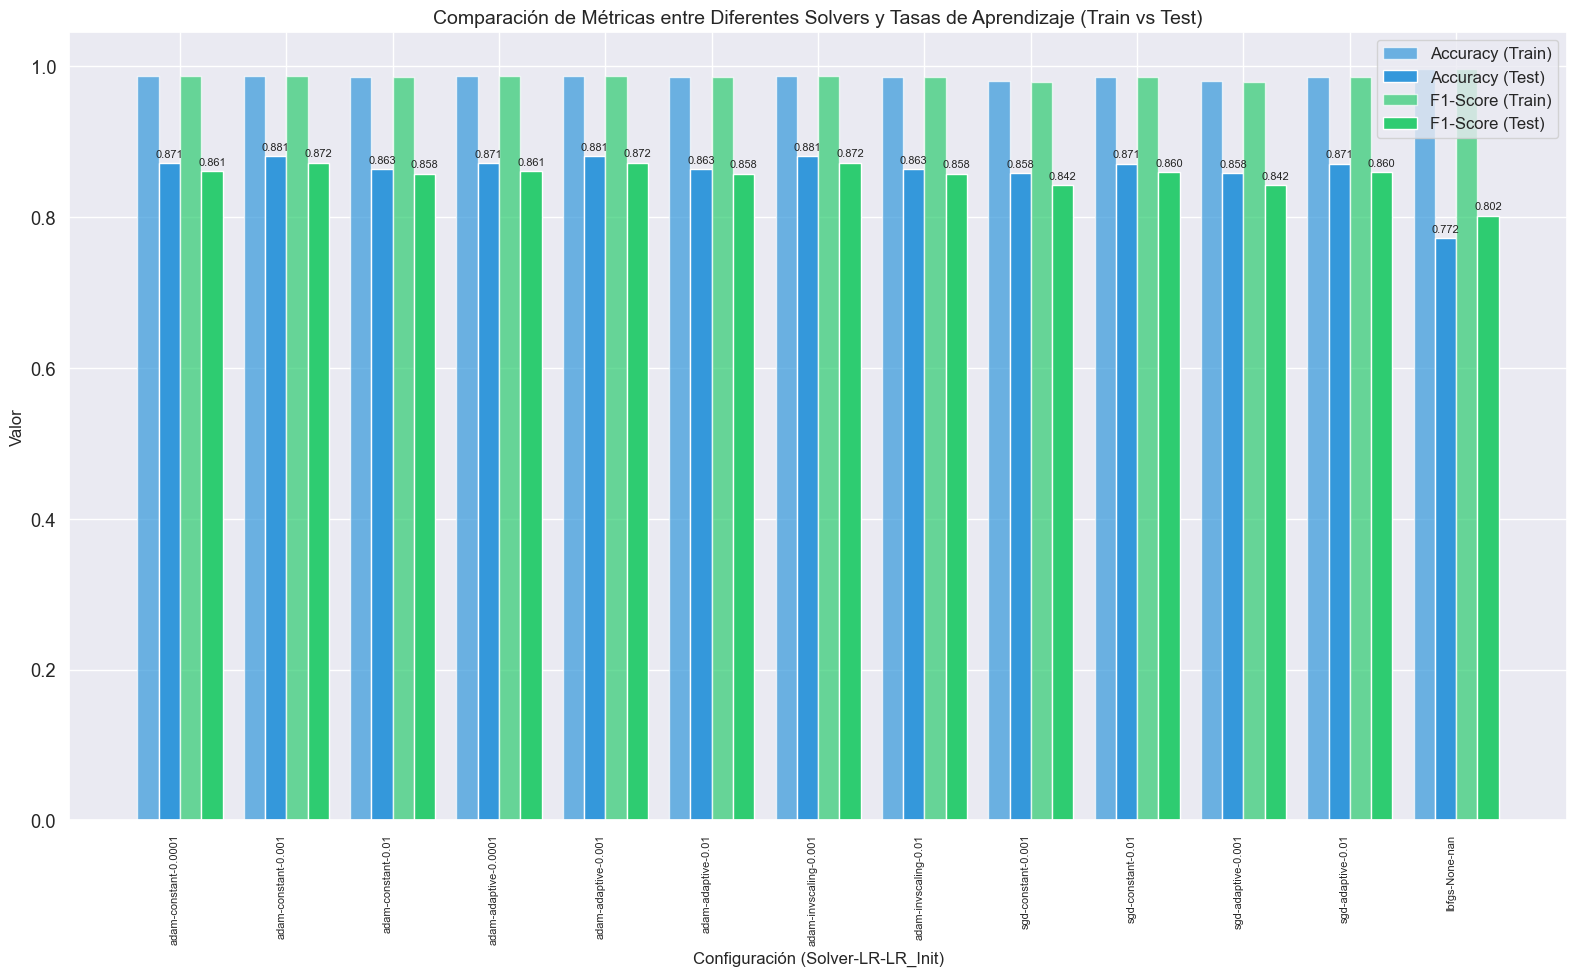

<Figure size 1400x800 with 0 Axes>

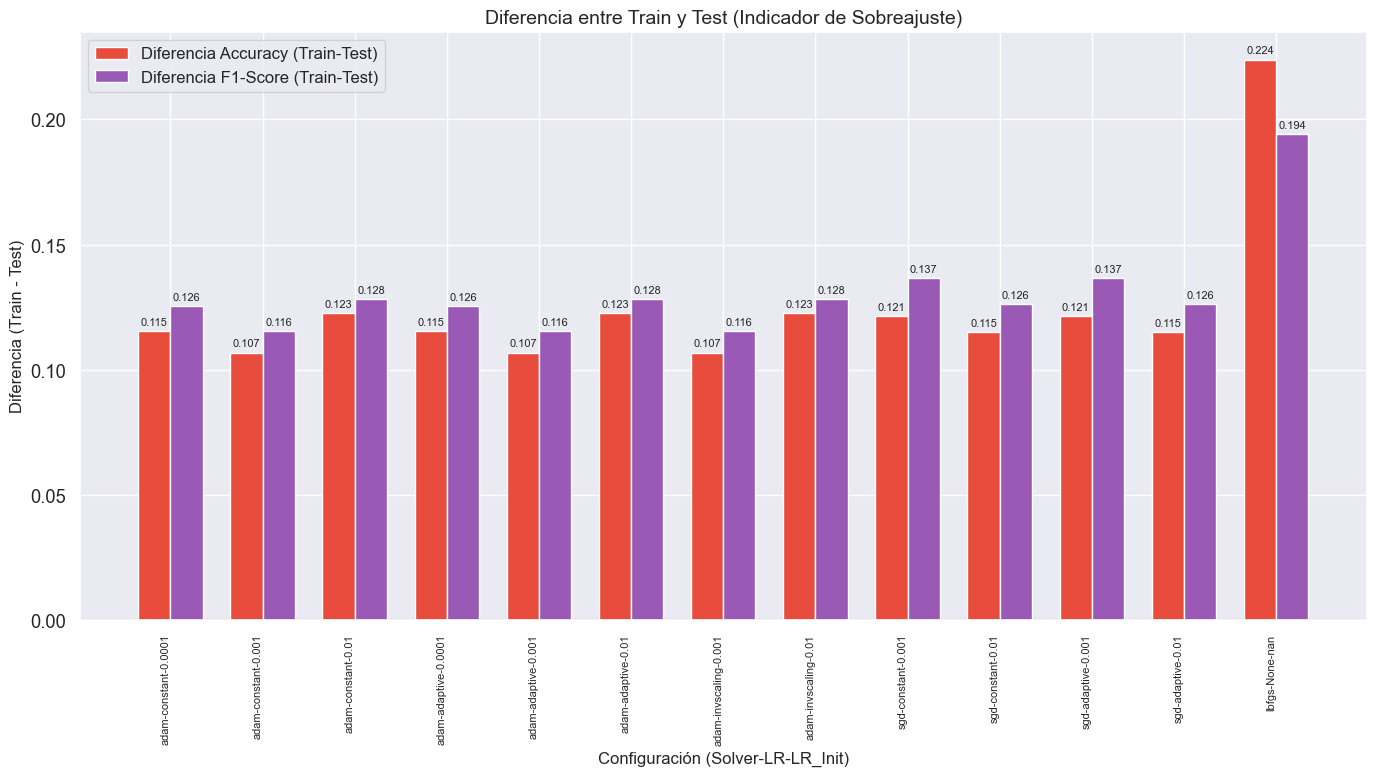

In [39]:
# Experimentación con diferentes solvers y tasas de aprendizaje
def experimentar_solvers_learning_rates():
    print("\n===== EXPERIMENTACIÓN CON DIFERENTES SOLVERS Y TASAS DE APRENDIZAJE =====")
    
    # Definir explícitamente las mejores arquitecturas y activaciones
    mejores_arquitecturas = [
        {
            'Arquitectura': 'Una capa oculta (128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (128,)
        },
        {
            'Arquitectura': 'Dos capas ocultas (256, 128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (256, 128)
        },
        {
            'Arquitectura': 'Una capa oculta (64 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (64,)
        }
    ]
    
    # Seleccionar la mejor arquitectura
    mejor_arquitectura_idx = 0  # 0 = primera arquitectura, 1 = segunda, 2 = tercera
    mejor_arquitectura_info = mejores_arquitecturas[mejor_arquitectura_idx]
    
    mejor_arquitectura_nombre = mejor_arquitectura_info['Arquitectura']
    mejor_activacion = mejor_arquitectura_info['Activación']
    mejor_arquitectura = mejor_arquitectura_info['hidden_layer_sizes']
    
    print(f"Usando la mejor combinación: {mejor_arquitectura_nombre} con activación {mejor_activacion}")
    
    # Definir diferentes configuraciones para probar
    configuraciones = [
        # Adam con diferentes tasas y estrategias
        ('adam', 'constant', 0.0001),
        ('adam', 'constant', 0.001),
        ('adam', 'constant', 0.01),
        ('adam', 'adaptive', 0.0001),
        ('adam', 'adaptive', 0.001),
        ('adam', 'adaptive', 0.01),
        ('adam', 'invscaling', 0.001),
        ('adam', 'invscaling', 0.01),
        
        # SGD con diferentes tasas y estrategias
        ('sgd', 'constant', 0.001),
        ('sgd', 'constant', 0.01),
        ('sgd', 'adaptive', 0.001),
        ('sgd', 'adaptive', 0.01),
        
        ('lbfgs', None, None)
    ]
    
    # Parámetros base
    params_base = {
        'hidden_layer_sizes': mejor_arquitectura,
        'activation': mejor_activacion,
        'alpha': 0.0005,
        'batch_size': 64,
        'max_iter': 200,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'random_state': RANDOM_SEED
    }
    
    # Resultados
    resultados = []
    
    #  Probar cada configuración
    for solver, learning_rate, learning_rate_init in configuraciones:
        # Nombre de la configuración
        if solver == 'lbfgs':
            nombre_config = f"Solver: {solver}"
        else:
            nombre_config = f"Solver: {solver}, LR: {learning_rate}, LR_init: {learning_rate_init}"
        
        print(f"\nProbando configuración: {nombre_config}")
        
        # Actualizar parámetros
        params = params_base.copy()
        params['solver'] = solver
        
        if solver != 'lbfgs':
            params['learning_rate'] = learning_rate
            params['learning_rate_init'] = learning_rate_init
        
        # Crear y entrenar modelo
        modelo = MLPClassifier(**params)
        
        start_time = time.time()
        modelo.fit(X_train_reducido_scaled, y_train_simple)
        training_time = time.time() - start_time
        
        # Evaluar en conjunto de entrenamiento
        y_pred_train = modelo.predict(X_train_reducido_scaled)
        accuracy_train = accuracy_score(y_train_simple, y_pred_train)
        f1_train = f1_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
        mcc_train = matthews_corrcoef(y_train_simple, y_pred_train)
        precision_train = precision_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
        recall_train = recall_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
        
        # Evaluar en conjunto de prueba
        y_pred_test = modelo.predict(X_test_reducido_scaled)
        accuracy_test = accuracy_score(y_test_simple, y_pred_test)
        f1_test = f1_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
        mcc_test = matthews_corrcoef(y_test_simple, y_pred_test)
        precision_test = precision_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
        recall_test = recall_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
                
        # Guardar resultados
        resultados.append({
            'Solver': solver,
            'Learning_Rate': learning_rate,
            'Learning_Rate_Init': learning_rate_init,
            'Arquitectura': mejor_arquitectura_nombre,
            'Activación': mejor_activacion,
            'Accuracy_Train': accuracy_train,
            'Precision_Train': precision_train,
            'Recall_Train': recall_train,
            'F1-Score_Train': f1_train,
            'MCC_Train': mcc_train,
            'Accuracy_Test': accuracy_test,
            'Precision_Test': precision_test,
            'Recall_Test': recall_test,
            'F1-Score_Test': f1_test,
            'MCC_Test': mcc_test,
            'Tiempo (s)': training_time,
            'Num_Iteraciones': modelo.n_iter_,
            'Convergencia': modelo.n_iter_ < params['max_iter']
        })

        print(f"  TRAIN - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, MCC: {mcc_train:.4f}")
        print(f"  TEST  - Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, MCC: {mcc_test:.4f}")
        print(f"  Tiempo: {training_time:.2f} segundos")
        print(f"  Iteraciones: {modelo.n_iter_}")
        print(f"  Convergió: {'Sí' if modelo.n_iter_ < params['max_iter'] else 'No'}")
    
    # Crear DataFrame con resultados
    resultados_df = pd.DataFrame(resultados)
    print("\nResumen de resultados:")
    print(resultados_df)
    
    # Ordenar por F1-Score en test
    resultados_df_sorted = resultados_df.sort_values('F1-Score_Test', ascending=False).reset_index(drop=True)
    print("\nMejores configuraciones por F1-Score en TEST:")
    print(resultados_df_sorted.head(5))
    
    # Visualizar resultados
    plt.figure(figsize=(16, 10))
    
    # Preparar datos para visualización
    configs = [f"{row['Solver']}-{row['Learning_Rate']}-{row['Learning_Rate_Init']}" for _, row in resultados_df.iterrows()]
    accuracy_train = resultados_df['Accuracy_Train']
    accuracy_test = resultados_df['Accuracy_Test']
    f1_train = resultados_df['F1-Score_Train']
    f1_test = resultados_df['F1-Score_Test']
    
    # Crear gráfico de barras agrupadas
    x = np.arange(len(configs))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(16, 10))
    rects1 = ax.bar(x - width*1.5, accuracy_train, width, label='Accuracy (Train)', color='#3498db', alpha=0.7)
    rects2 = ax.bar(x - width/2, accuracy_test, width, label='Accuracy (Test)', color='#3498db')
    rects3 = ax.bar(x + width/2, f1_train, width, label='F1-Score (Train)', color='#2ecc71', alpha=0.7)
    rects4 = ax.bar(x + width*1.5, f1_test, width, label='F1-Score (Test)', color='#2ecc71')
    
    # Añadir etiquetas y leyenda
    ax.set_xlabel('Configuración (Solver-LR-LR_Init)', fontsize=12)
    ax.set_ylabel('Valor', fontsize=12)
    ax.set_title('Comparación de Métricas entre Diferentes Solvers y Tasas de Aprendizaje (Train vs Test)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(configs, rotation=90, ha='right', fontsize=8)
    ax.legend(fontsize=12)
    
    # Añadir valores sobre las barras (solo para test)
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)
    
    autolabel(rects2)  # Accuracy Test
    autolabel(rects4)  # F1-Score Test
    
    plt.tight_layout()
    plt.savefig('comparacion_solvers_lr_train_test.png', dpi=300)
    plt.show()
    
    # Visualizar diferencia entre train y test
    plt.figure(figsize=(14, 8))
    
    # Calcular diferencia entre train y test
    diff_accuracy = resultados_df['Accuracy_Train'] - resultados_df['Accuracy_Test']
    diff_f1 = resultados_df['F1-Score_Train'] - resultados_df['F1-Score_Test']
    
    # Crear gráfico de barras
    x = np.arange(len(configs))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, diff_accuracy, width, label='Diferencia Accuracy (Train-Test)', color='#e74c3c')
    rects2 = ax.bar(x + width/2, diff_f1, width, label='Diferencia F1-Score (Train-Test)', color='#9b59b6')
    
    # Añadir etiquetas y leyenda
    ax.set_xlabel('Configuración (Solver-LR-LR_Init)', fontsize=12)
    ax.set_ylabel('Diferencia (Train - Test)', fontsize=12)
    ax.set_title('Diferencia entre Train y Test (Indicador de Sobreajuste)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(configs, rotation=90, ha='right', fontsize=8)
    ax.legend(fontsize=12)
    
    # Añadir línea horizontal en y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Añadir valores sobre las barras
    autolabel(rects1)
    autolabel(rects2)
    
    plt.tight_layout()
    plt.savefig('diferencia_train_test_solvers_lr.png', dpi=300)
    plt.show()
    
    return resultados_df

resultados_solvers_lr = experimentar_solvers_learning_rates()


===== EXPERIMENTACIÓN CON DIFERENTES VALORES DE REGULARIZACIÓN (ALPHA) Y BATCH SIZE =====
Usando la mejor configuración:
  Arquitectura: Una capa oculta (128 neuronas)
  Activación: logistic
  Solver: adam
  Learning Rate: constant
  Learning Rate Init: 0.001

Probando configuración: Alpha: 0.0001, Batch Size: 16
  TRAIN - Accuracy: 0.9867, Precision: 0.9872, Recall: 0.9867, F1: 0.9867, MCC: 0.9864
  TEST  - Accuracy: 0.8842, Precision: 0.8808, Recall: 0.8842, F1: 0.8772, MCC: 0.8812
  Tiempo: 940.57 segundos
  Iteraciones: 26
  Convergió: Sí

Probando configuración: Alpha: 0.0001, Batch Size: 32
  TRAIN - Accuracy: 0.9878, Precision: 0.9881, Recall: 0.9878, F1: 0.9877, MCC: 0.9875
  TEST  - Accuracy: 0.8831, Precision: 0.8774, Recall: 0.8831, F1: 0.8749, MCC: 0.8801
  Tiempo: 685.34 segundos
  Iteraciones: 38
  Convergió: Sí

Probando configuración: Alpha: 0.0001, Batch Size: 64
  TRAIN - Accuracy: 0.9874, Precision: 0.9878, Recall: 0.9874, F1: 0.9873, MCC: 0.9871
  TEST  - Accuracy:

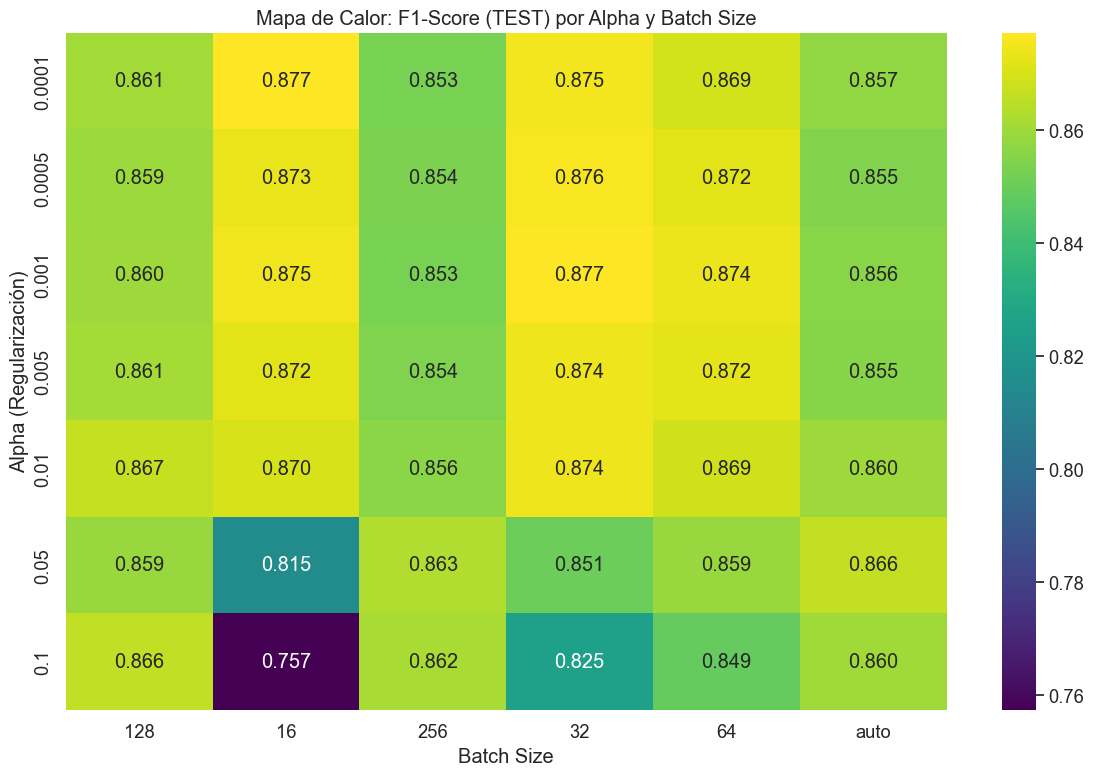

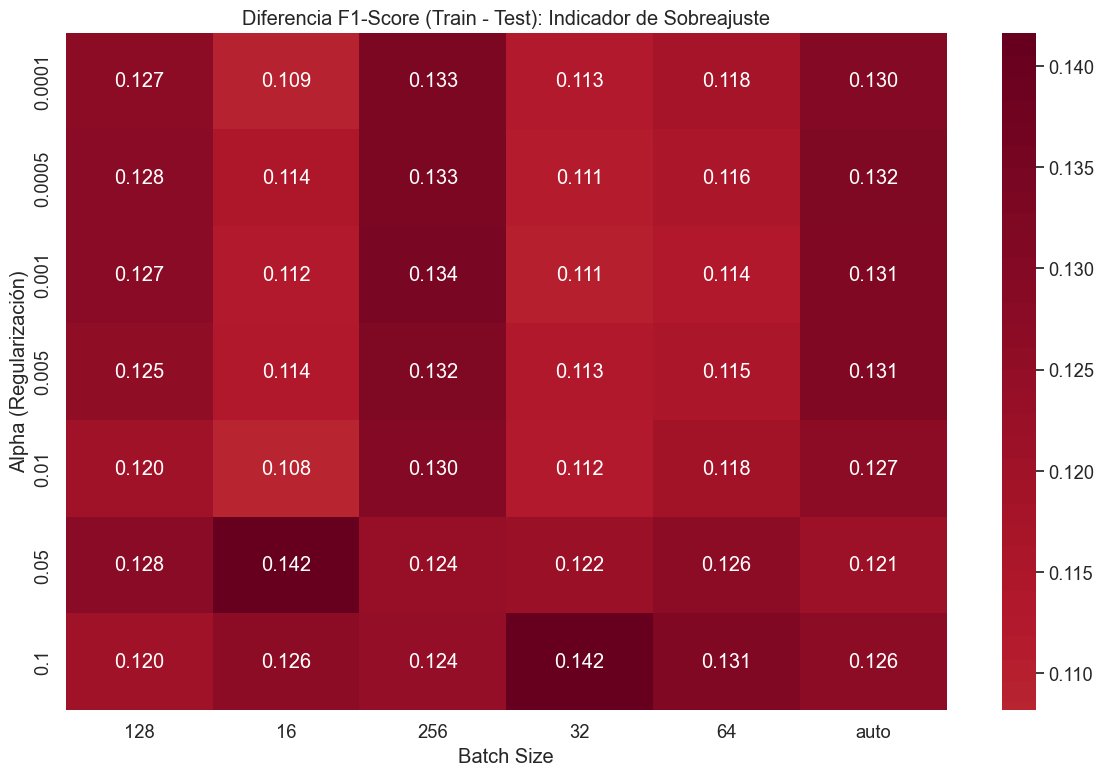

In [42]:
# Experimentación con diferentes valores de regularización (alpha) y batch size
def experimentar_alpha_batch():
    print("\n===== EXPERIMENTACIÓN CON DIFERENTES VALORES DE REGULARIZACIÓN (ALPHA) Y BATCH SIZE =====")
    
    # Obtener la mejor configuración de solver y learning rate
    mejor_config = resultados_solvers_lr.sort_values('F1-Score_Test', ascending=False).iloc[0]
    mejor_solver = mejor_config['Solver']
    mejor_lr = mejor_config['Learning_Rate'] if mejor_config['Learning_Rate'] != 'N/A' else None
    mejor_lr_init = float(mejor_config['Learning_Rate_Init']) if mejor_config['Learning_Rate_Init'] != 'N/A' else None
    
    # Definir explícitamente las mejores arquitecturas y activaciones
    mejores_arquitecturas = [
        {
            'Arquitectura': 'Una capa oculta (128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (128,)
        },
        {
            'Arquitectura': 'Dos capas ocultas (256, 128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (256, 128)
        },
        {
            'Arquitectura': 'Una capa oculta (64 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (64,)
        }
    ]
    
    # Seleccionar la mejor arquitectura
    mejor_arquitectura_idx = 0  # 0 = primera arquitectura, 1 = segunda, 2 = tercera
    mejor_arquitectura_info = mejores_arquitecturas[mejor_arquitectura_idx]
    
    mejor_arquitectura_nombre = mejor_arquitectura_info['Arquitectura']
    mejor_activacion = mejor_arquitectura_info['Activación']
    mejor_arquitectura = mejor_arquitectura_info['hidden_layer_sizes']
    
    print(f"Usando la mejor configuración:")
    print(f"  Arquitectura: {mejor_arquitectura_nombre}")
    print(f"  Activación: {mejor_activacion}")
    print(f"  Solver: {mejor_solver}")
    print(f"  Learning Rate: {mejor_lr}")
    print(f"  Learning Rate Init: {mejor_lr_init}")
    
    # Definir diferentes valores de alpha y batch_size para probar
    alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
    batch_sizes = [16, 32, 64, 128, 256, 'auto']
    
    # Parámetros base
    params_base = {
        'hidden_layer_sizes': mejor_arquitectura,
        'activation': mejor_activacion,
        'solver': mejor_solver,
        'max_iter': 200,
        'early_stopping': True,
        'validation_fraction': 0.1,
        'n_iter_no_change': 10,
        'random_state': RANDOM_SEED
    }
    
    # Añadir learning_rate y learning_rate_init si no es lbfgs
    if mejor_solver != 'lbfgs':
        params_base['learning_rate'] = mejor_lr
        params_base['learning_rate_init'] = mejor_lr_init
    
    # Resultados
    resultados = []
    
    # Probar cada combinación de alpha y batch_size
    for alpha in alphas:
        for batch_size in batch_sizes:
            nombre_config = f"Alpha: {alpha}, Batch Size: {batch_size}"
            print(f"\nProbando configuración: {nombre_config}")
            
            # Actualizar parámetros
            params = params_base.copy()
            params['alpha'] = alpha
            params['batch_size'] = batch_size
            
            # Crear y entrenar modelo
            modelo = MLPClassifier(**params)
            
            start_time = time.time()
            modelo.fit(X_train_reducido_scaled, y_train_simple)
            training_time = time.time() - start_time
            
            # Evaluar en conjunto de entrenamiento
            y_pred_train = modelo.predict(X_train_reducido_scaled)
            accuracy_train = accuracy_score(y_train_simple, y_pred_train)
            f1_train = f1_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
            mcc_train = matthews_corrcoef(y_train_simple, y_pred_train)
            precision_train = precision_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)
            recall_train = recall_score(y_train_simple, y_pred_train, average='weighted', zero_division=0)

            # Evaluar en conjunto de prueba
            y_pred_test = modelo.predict(X_test_reducido_scaled)
            accuracy_test = accuracy_score(y_test_simple, y_pred_test)
            f1_test = f1_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            mcc_test = matthews_corrcoef(y_test_simple, y_pred_test)
            precision_test = precision_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            recall_test = recall_score(y_test_simple, y_pred_test, average='weighted', zero_division=0)
            
            # Guardar resultados
            resultados.append({
                'Alpha': alpha,
                'Batch_Size': str(batch_size),
                'Accuracy_Train': accuracy_train,
                'Precision_Train': precision_train,
                'Recall_Train': recall_train,
                'F1-Score_Train': f1_train,
                'MCC_Train': mcc_train,
                'Accuracy_Test': accuracy_test,
                'Precision_Test': precision_test,
                'Recall_Test': recall_test,
                'F1-Score_Test': f1_test,
                'MCC_Test': mcc_test,
                'Tiempo (s)': training_time,
                'Num_Iteraciones': modelo.n_iter_,
                'Convergencia': modelo.n_iter_ < params['max_iter']
            })

            print(f"  TRAIN - Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1: {f1_train:.4f}, MCC: {mcc_train:.4f}")
            print(f"  TEST  - Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1: {f1_test:.4f}, MCC: {mcc_test:.4f}")
            print(f"  Tiempo: {training_time:.2f} segundos")
            print(f"  Iteraciones: {modelo.n_iter_}")
            print(f"  Convergió: {'Sí' if modelo.n_iter_ < params['max_iter'] else 'No'}")
    
    # Crear DataFrame con resultados
    resultados_df = pd.DataFrame(resultados)
    print("\nResumen de resultados:")
    print(resultados_df)
    
    # Ordenar por F1-Score en test
    resultados_df_sorted = resultados_df.sort_values('F1-Score_Test', ascending=False).reset_index(drop=True)
    print("\nMejores configuraciones por F1-Score en TEST:")
    print(resultados_df_sorted.head(5))
    
    # Crear mapa de calor para visualizar mejor las combinaciones
    plt.figure(figsize=(12, 8))
    
    # Crear matriz para el mapa de calor
    matriz_pivot = resultados_df.pivot_table(index='Alpha', columns='Batch_Size', values='F1-Score_Test')
    
    # Crear mapa de calor
    sns.heatmap(matriz_pivot, annot=True, fmt='.3f', cmap='viridis')
    
    plt.title('Mapa de Calor: F1-Score (TEST) por Alpha y Batch Size')
    plt.xlabel('Batch Size')
    plt.ylabel('Alpha (Regularización)')
    plt.tight_layout()
    plt.savefig('heatmap_alpha_batch_test.png', dpi=300)
    plt.show()
    
    # Crear mapa de calor para la diferencia entre train y test
    plt.figure(figsize=(12, 8))
    
    # Calcular diferencia entre train y test para cada combinación
    resultados_df['Diff_F1'] = resultados_df['F1-Score_Train'] - resultados_df['F1-Score_Test']
    
    # Crear matriz para el mapa de calor
    matriz_diff = resultados_df.pivot_table(index='Alpha', columns='Batch_Size', values='Diff_F1')
    
    # Crear mapa de calor
    sns.heatmap(matriz_diff, annot=True, fmt='.3f', cmap='RdBu_r', center=0)
    
    plt.title('Diferencia F1-Score (Train - Test): Indicador de Sobreajuste')
    plt.xlabel('Batch Size')
    plt.ylabel('Alpha (Regularización)')
    plt.tight_layout()
    plt.savefig('heatmap_sobreajuste_alpha_batch.png', dpi=300)
    plt.show()
    
    return resultados_df

resultados_alpha_batch = experimentar_alpha_batch()

In [45]:
def entrenar_modelo_final():
    print("\n===== ENTRENAMIENTO DEL MODELO FINAL OPTIMIZADO =====")
    
    # Obtener la mejor configuración de alpha y batch_size
    mejor_config = resultados_alpha_batch.sort_values('F1-Score_Test', ascending=False).iloc[0]
    mejor_alpha = mejor_config['Alpha']
    mejor_batch_size = int(mejor_config['Batch_Size'])  # Asegurarse que sea int
    
    # Obtener la mejor configuración de solver y learning rate
    mejor_solver_config = resultados_solvers_lr.sort_values('F1-Score_Test', ascending=False).iloc[0]
    mejor_solver = mejor_solver_config['Solver']
    mejor_lr = mejor_solver_config['Learning_Rate'] if mejor_solver_config['Learning_Rate'] != 'N/A' else None
    mejor_lr_init = float(mejor_solver_config['Learning_Rate_Init']) if mejor_solver_config['Learning_Rate_Init'] != 'N/A' else None
    
    # Definir arquitecturas y activaciones disponibles
    mejores_arquitecturas = [
        {
            'Arquitectura': 'Una capa oculta (128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (128,)
        },
        {
            'Arquitectura': 'Dos capas ocultas (256, 128 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (256, 128)
        },
        {
            'Arquitectura': 'Una capa oculta (64 neuronas)',
            'Activación': 'logistic',
            'hidden_layer_sizes': (64,)
        }
    ]
    
    # Seleccionar la mejor arquitectura
    mejor_arquitectura_idx = 0  # Puedes cambiar esto si decides otra
    mejor_arquitectura_info = mejores_arquitecturas[mejor_arquitectura_idx]
    
    mejor_arquitectura_nombre = mejor_arquitectura_info['Arquitectura']
    mejor_activacion = mejor_arquitectura_info['Activación']
    mejor_arquitectura = mejor_arquitectura_info['hidden_layer_sizes']
    
    print(f"Configuración óptima encontrada:")
    print(f"  Arquitectura: {mejor_arquitectura_nombre}")
    print(f"  Activación: {mejor_activacion}")
    print(f"  Solver: {mejor_solver}")
    print(f"  Learning Rate: {mejor_lr}")
    print(f"  Learning Rate Init: {mejor_lr_init}")
    print(f"  Alpha: {mejor_alpha}")
    print(f"  Batch Size: {mejor_batch_size}")
    
    print("\nEntrenando modelo optimizado...")

    # Construir parámetros finales
    params_optimos = {
        'hidden_layer_sizes': mejor_arquitectura,
        'activation': mejor_activacion,
        'solver': mejor_solver,
        'alpha': mejor_alpha,
        'batch_size': mejor_batch_size,
        'learning_rate_init': mejor_lr_init
    }
    
    if mejor_lr is not None:
        params_optimos['learning_rate'] = mejor_lr

    modelo_optimizado = MLPClassifier(**params_optimos)

    start_time = time.time()
    modelo_optimizado.fit(X_train_reducido_scaled, y_train_simple)
    training_time = time.time() - start_time
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

    # Predicciones y métricas
    y_train_pred = modelo_optimizado.predict(X_train_reducido_scaled)
    y_test_pred = modelo_optimizado.predict(X_test_reducido_scaled)

    accuracy_train = accuracy_score(y_train_simple, y_train_pred)
    f1_train = f1_score(y_train_simple, y_train_pred, average='macro')
    mcc_train = matthews_corrcoef(y_train_simple, y_train_pred)

    accuracy_test = accuracy_score(y_test_simple, y_test_pred)
    f1_test = f1_score(y_test_simple, y_test_pred, average='macro')
    mcc_test = matthews_corrcoef(y_test_simple, y_test_pred)

    return modelo_optimizado, params_optimos, {
        'accuracy_train': accuracy_train,
        'f1_train': f1_train,
        'mcc_train': mcc_train,
        'accuracy_test': accuracy_test,
        'f1_test': f1_test,
        'mcc_test': mcc_test
    }

modelo_final, params_finales, metricas_finales = entrenar_modelo_final()


===== ENTRENAMIENTO DEL MODELO FINAL OPTIMIZADO =====
Configuración óptima encontrada:
  Arquitectura: Una capa oculta (128 neuronas)
  Activación: logistic
  Solver: adam
  Learning Rate: constant
  Learning Rate Init: 0.001
  Alpha: 0.0001
  Batch Size: 16

Entrenando modelo optimizado...
Tiempo de entrenamiento: 1013.35 segundos



===== COMPARACIÓN FINAL ENTRE MODELO BASE Y MODELO OPTIMIZADO =====
Creando modelo base para comparación...

Comparación de métricas en conjunto de PRUEBA:
     Métrica  Modelo Base  Modelo Optimizado  Mejora (%)
0   Accuracy     0.796870           0.881739   10.650371
1  Precision     0.788609           0.879367   11.508591
2     Recall     0.796870           0.881739   10.650371
3   F1-Score     0.785759           0.874160   11.250433
4        MCC     0.791561           0.878740   11.013663


<Figure size 1200x800 with 0 Axes>

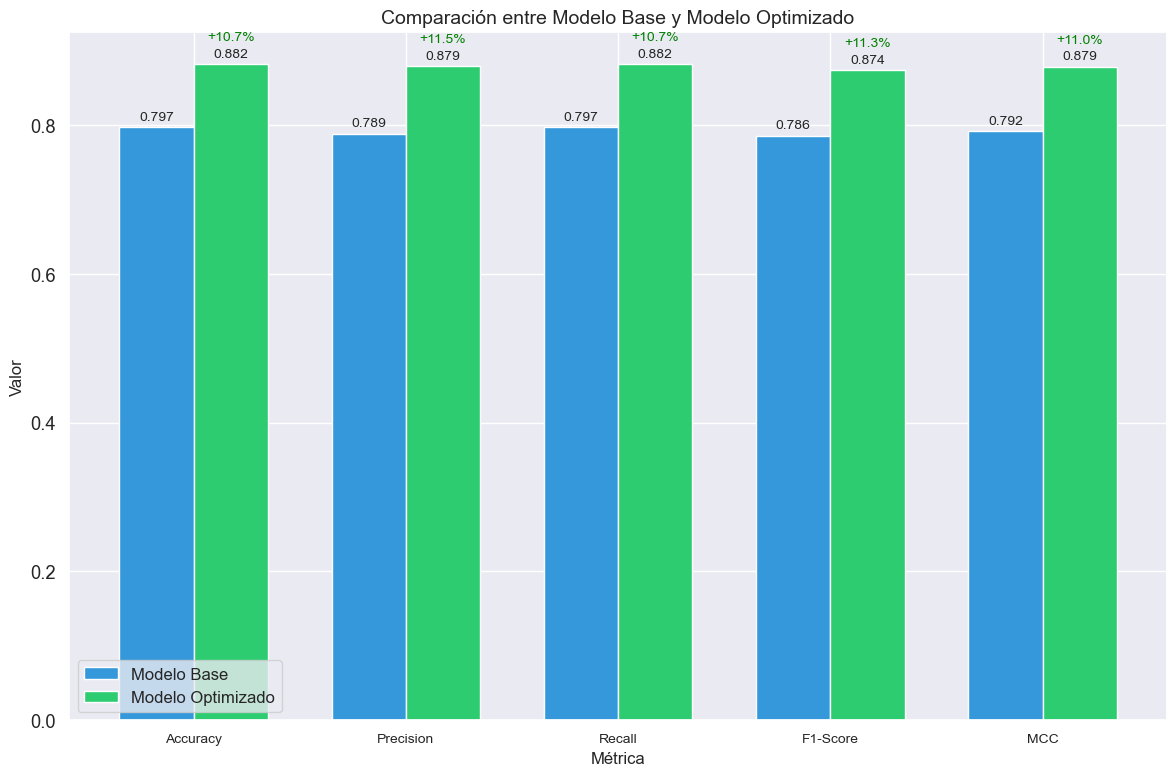

<Figure size 1400x1200 with 0 Axes>

In [57]:
# Comparación final entre modelo base y modelo optimizado
def comparacion_final():
    print("\n===== COMPARACIÓN FINAL ENTRE MODELO BASE Y MODELO OPTIMIZADO =====")
    
    # Crear modelo base para comparación
    print("Creando modelo base para comparación...")
    params_base = {
        'hidden_layer_sizes': (100,),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 0.0001,
        'batch_size': 'auto',
        'learning_rate': 'constant',
        'learning_rate_init': 0.001,
        'max_iter': 200,
        'random_state': RANDOM_SEED
    }
    
    nn_base = MLPClassifier(**params_base)
    nn_base.fit(X_train_reducido_scaled, y_train_simple)
    
    # Evaluar modelo base en conjunto de prueba
    y_pred_base = nn_base.predict(X_test_reducido_scaled)
    accuracy_base = accuracy_score(y_test_simple, y_pred_base)
    precision_base = precision_score(y_test_simple, y_pred_base, average='weighted', zero_division=0)
    recall_base = recall_score(y_test_simple, y_pred_base, average='weighted', zero_division=0)
    f1_base = f1_score(y_test_simple, y_pred_base, average='weighted', zero_division=0)
    mcc_base = matthews_corrcoef(y_test_simple, y_pred_base)
    
    # Evaluar modelo optimizado en conjunto de prueba
    y_pred_opt = modelo_final.predict(X_test_reducido_scaled)
    accuracy_opt = accuracy_score(y_test_simple, y_pred_opt)
    precision_opt = precision_score(y_test_simple, y_pred_opt, average='weighted', zero_division=0)
    recall_opt = recall_score(y_test_simple, y_pred_opt, average='weighted', zero_division=0)
    f1_opt = f1_score(y_test_simple, y_pred_opt, average='weighted', zero_division=0)
    mcc_opt = matthews_corrcoef(y_test_simple, y_pred_opt)
    
    # Crear DataFrame para comparación
    comparacion = pd.DataFrame({
        'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MCC'],
        'Modelo Base': [accuracy_base, precision_base, recall_base, f1_base, mcc_base],
        'Modelo Optimizado': [accuracy_opt, precision_opt, recall_opt, f1_opt, mcc_opt]
    })
    
    # Calcular mejora porcentual
    comparacion['Mejora (%)'] = ((comparacion['Modelo Optimizado'] - comparacion['Modelo Base']) / 
                                comparacion['Modelo Base'] * 100)
    
    # Mostrar tabla de comparación
    print("\nComparación de métricas en conjunto de PRUEBA:")
    print(comparacion)
    
    # Visualizar comparación
    plt.figure(figsize=(12, 8))
    
    # Preparar datos para visualización
    metricas = comparacion['Métrica']
    base = comparacion['Modelo Base']
    optimizado = comparacion['Modelo Optimizado']
    
    # Crear gráfico de barras agrupadas
    x = np.arange(len(metricas))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, base, width, label='Modelo Base', color='#3498db')
    rects2 = ax.bar(x + width/2, optimizado, width, label='Modelo Optimizado', color='#2ecc71')
    
    # Añadir etiquetas y leyenda
    ax.set_xlabel('Métrica', fontsize=12)
    ax.set_ylabel('Valor', fontsize=12)
    ax.set_title('Comparación entre Modelo Base y Modelo Optimizado', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(metricas, fontsize=10)
    ax.legend(fontsize=12)
    
    # Añadir valores sobre las barras
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    autolabel(rects1)
    autolabel(rects2)
    
    # Añadir porcentaje de mejora
    for i, rect in enumerate(rects2):
        height = rect.get_height()
        mejora = comparacion['Mejora (%)'].iloc[i]
        ax.annotate(f'+{mejora:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 15),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, color='green')
    
    plt.tight_layout()
    plt.savefig('comparacion_final.png', dpi=300)
    plt.show()
    
    # Visualizar matriz de confusión del modelo optimizado
    plt.figure(figsize=(14, 12))
    
    # Obtener predicciones
    y_pred = modelo_final.predict(X_test_reducido_scaled)
    
    # Calcular matriz de confusión
    cm = confusion_matrix(y_test_simple, y_pred)
    
    return comparacion

comparacion_df = comparacion_final()

In [49]:
def mostrar_errores_comunes(y_true, y_pred, etiquetas_clases=None, top_n=20):
    # Calcular matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    
    # Etiquetas si no se proporcionan
    if etiquetas_clases is None:
        etiquetas_clases = sorted(np.unique(np.concatenate((y_true, y_pred))))

    # Encontrar errores (excluyendo la diagonal)
    errores = []
    for i in range(len(cm)):
        for j in range(len(cm)):
            if i != j and cm[i, j] > 0:
                errores.append((etiquetas_clases[i], etiquetas_clases[j], cm[i, j]))

    # Ordenar los errores por frecuencia
    errores_ordenados = sorted(errores, key=lambda x: x[2], reverse=True)

    # Mostrar los errores más comunes
    print(f"\nTop {top_n} confusiones más comunes:")
    for etiqueta_real, etiqueta_predicha, cantidad in errores_ordenados[:top_n]:
        print(f"Etiqueta real '{etiqueta_real}' fue predicha como '{etiqueta_predicha}' {cantidad} veces.")

# Llamada a la función
mostrar_errores_comunes(y_test_simple, modelo_final.predict(X_test_reducido_scaled))


Top 20 confusiones más comunes:
Etiqueta real '141' fue predicha como '144' 8 veces.
Etiqueta real '140' fue predicha como '141' 5 veces.
Etiqueta real '144' fue predicha como '141' 5 veces.
Etiqueta real '17' fue predicha como '18' 4 veces.
Etiqueta real '177' fue predicha como '144' 4 veces.
Etiqueta real '68' fue predicha como '32' 3 veces.
Etiqueta real '69' fue predicha como '56' 3 veces.
Etiqueta real '78' fue predicha como '68' 3 veces.
Etiqueta real '134' fue predicha como '135' 3 veces.
Etiqueta real '141' fue predicha como '140' 3 veces.
Etiqueta real '143' fue predicha como '144' 3 veces.
Etiqueta real '32' fue predicha como '144' 2 veces.
Etiqueta real '38' fue predicha como '20' 2 veces.
Etiqueta real '42' fue predicha como '18' 2 veces.
Etiqueta real '52' fue predicha como '58' 2 veces.
Etiqueta real '58' fue predicha como '18' 2 veces.
Etiqueta real '58' fue predicha como '53' 2 veces.
Etiqueta real '69' fue predicha como '75' 2 veces.
Etiqueta real '77' fue predicha co

In [78]:
import random
import joblib

# Cargar el LabelEncoder
encoder = joblib.load('label_encoder_simple_reducido.pkl')
etiquetas_clases = encoder.classes_

def mostrar_varios_ejemplos_prediccion(modelo, X_test, y_test, etiquetas_clases=None, cantidad=10):
    print("===== EJEMPLOS DE PREDICCIÓN =====")
    indices_usados = set()

    for i in range(cantidad):
        # Asegurarse de no repetir el mismo índice
        while True:
            indice = random.randint(0, len(X_test) - 1)
            if indice not in indices_usados:
                indices_usados.add(indice)
                break

        muestra = X_test[indice].reshape(1, -1)
        prediccion = modelo.predict(muestra)[0]
        real = y_test[indice]

        if etiquetas_clases is not None:
            etiqueta_real = etiquetas_clases[real]
            etiqueta_predicha = etiquetas_clases[prediccion]
        else:
            etiqueta_real = real
            etiqueta_predicha = prediccion

        print(f"\nEjemplo {i+1}:")
        print(f" - Índice de muestra: {indice}")
        print(f" - Etiqueta real     : {etiqueta_real}")
        print(f" - Predicción modelo : {etiqueta_predicha}")

# Ejecutar la función con tus datos
mostrar_varios_ejemplos_prediccion(modelo_final, X_test_reducido_scaled, y_test_simple, etiquetas_clases)


===== EJEMPLOS DE PREDICCIÓN =====

Ejemplo 1:
 - Índice de muestra: 2594
 - Etiqueta real     : 06412
 - Predicción modelo : 03413

Ejemplo 2:
 - Índice de muestra: 1985
 - Etiqueta real     : 14612
 - Predicción modelo : 14612

Ejemplo 3:
 - Índice de muestra: 1697
 - Etiqueta real     : 14610
 - Predicción modelo : 14610

Ejemplo 4:
 - Índice de muestra: 655
 - Etiqueta real     : 14612
 - Predicción modelo : 14612

Ejemplo 5:
 - Índice de muestra: 1296
 - Etiqueta real     : 06113
 - Predicción modelo : 06113

Ejemplo 6:
 - Índice de muestra: 2167
 - Etiqueta real     : 05412
 - Predicción modelo : 05412

Ejemplo 7:
 - Índice de muestra: 2183
 - Etiqueta real     : 12114
 - Predicción modelo : 12114

Ejemplo 8:
 - Índice de muestra: 106
 - Etiqueta real     : 14611
 - Predicción modelo : 14611

Ejemplo 9:
 - Índice de muestra: 2424
 - Etiqueta real     : 19411
 - Predicción modelo : 19411

Ejemplo 10:
 - Índice de muestra: 1661
 - Etiqueta real     : 05419
 - Predicción modelo : 01